In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)

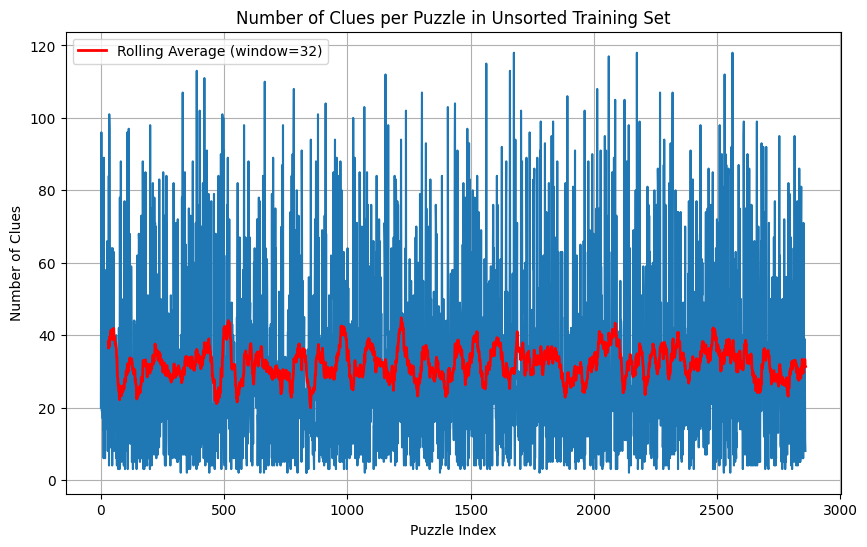

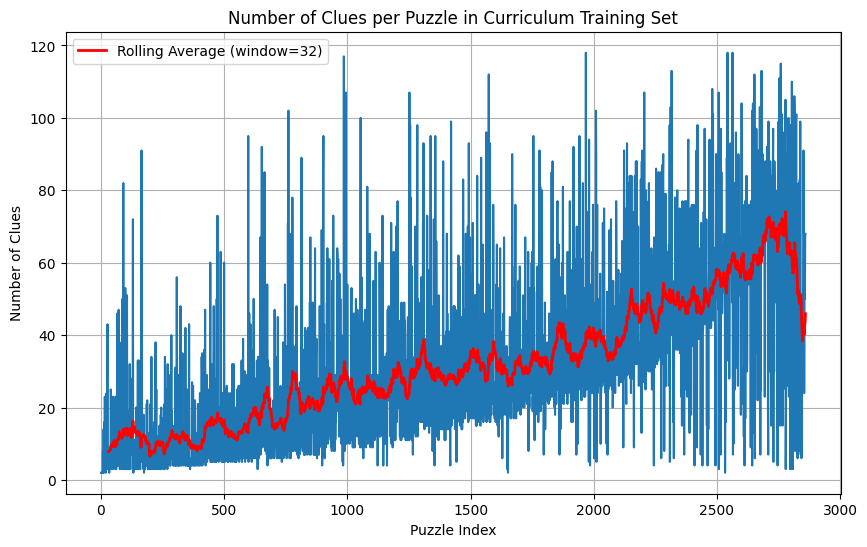

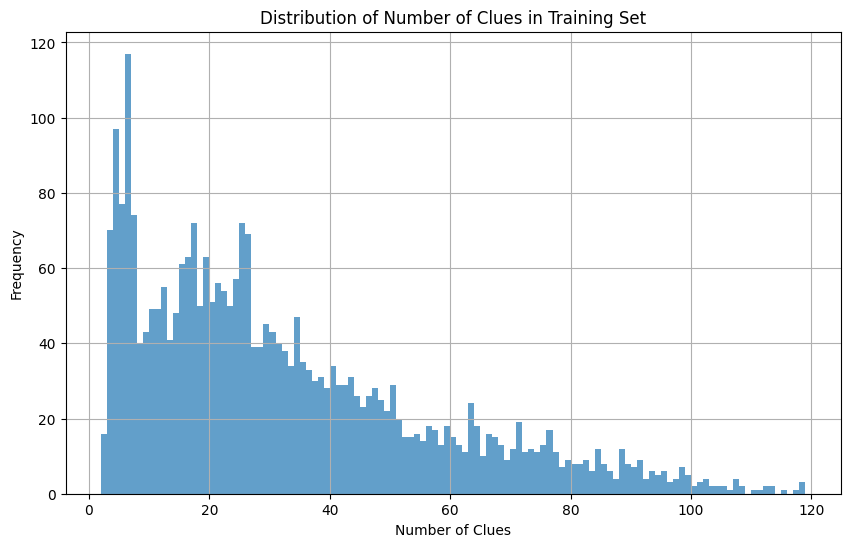

In [4]:
import matplotlib.pyplot as plt
import numpy as np

min_clues = min(x["num_clues"] for x in train_puzzles)
max_clues = max(x["num_clues"] for x in train_puzzles)

# Plot the unsorted training puzzle clues
plt.figure(figsize=(10, 6))
unsorted_clues = [puzzle["num_clues"] for puzzle in train_puzzles]
plt.plot(range(len(train_puzzles)), unsorted_clues)

# Calculate and plot rolling average
window_size = 32
rolling_avg = np.convolve(
    unsorted_clues, np.ones(window_size) / window_size, mode="valid"
)
plt.plot(
    range(window_size - 1, len(unsorted_clues)),
    rolling_avg,
    "r-",
    linewidth=2,
    label=f"Rolling Average (window={window_size})",
)

plt.xlabel("Puzzle Index")
plt.ylabel("Number of Clues")
plt.title("Number of Clues per Puzzle in Unsorted Training Set")
plt.legend()
plt.grid(True)
plt.show()

curriculum_train_puzzles = sorted(
    train_puzzles,
    key=lambda x: ((x["num_clues"] - min_clues) / (max_clues - min_clues))
    * random.random()
    + random.random() ** 30,
)

# Plot the number of clues for each puzzle in the training set
plt.figure(figsize=(10, 6))
clues = [puzzle["num_clues"] for puzzle in curriculum_train_puzzles]
plt.plot(range(len(curriculum_train_puzzles)), clues)

# Calculate and plot rolling average
window_size = 32
rolling_avg = np.convolve(clues, np.ones(window_size) / window_size, mode="valid")
plt.plot(
    range(window_size - 1, len(clues)),
    rolling_avg,
    "r-",
    linewidth=2,
    label=f"Rolling Average (window={window_size})",
)

plt.xlabel("Puzzle Index")
plt.ylabel("Number of Clues")
plt.title("Number of Clues per Puzzle in Curriculum Training Set")
plt.legend()
plt.grid(True)
plt.show()

# Plot the distribution of clues
plt.figure(figsize=(10, 6))
plt.hist(clues, bins=range(min(clues), max(clues) + 2), alpha=0.7)
plt.xlabel("Number of Clues")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Clues in Training Set")
plt.grid(True)
plt.show()

In [ ]:
api = art.LocalAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-005", base_model="NousResearch/Hermes-2-Theta-Llama-3-8B"
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 32
for i in range(await model.get_iteration(), len(curriculum_train_puzzles) // stride):
    async with model.openai_client(
        estimated_completion_tokens=350, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles
                ),
                pbar_desc="val",
                stream_chat_completions=8,
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in curriculum_train_puzzles[
                        i * stride : (i + 1) * stride
                    ]
                ),
                pbar_desc="train",
            ),
        )
    await model.log(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )

async with model.openai_client(
    estimated_completion_tokens=350, verbosity=2
) as openai_client:
    # Final evaluation
    val_groups, test_groups = await asyncio.gather(
        art.gather_trajectories(
            (rollout(openai_client, puzzle) for _ in range(4)) for puzzle in val_puzzles
        ),
        art.gather_trajectories(
            (rollout(openai_client, puzzle) for _ in range(4))
            for puzzle in test_puzzles
        ),
    )
await model.log(val_groups)
await model.log(test_groups)
await model.clear_iterations()